In [276]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from datetime import datetime

spark = SparkSession.builder. \
    config("spark.driver.memory", "2g"). \
    config("spark.executor.memory", "8g"). \
    config("spark.executor.cores", "4"). \
    config("spark.executor.instances", "1").appName("test").getOrCreate()


# group_on_both_results_dec_sev

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/07/24 12:46:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/07/24 12:46:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/07/24 12:46:05 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [277]:
zipcode_with_feats_df = spark.read.csv("/Users/prapul/final_mainzipcodes_zip_df_with_new_feats.csv", header = True, inferSchema = True, escape = "\"").drop("log_data").select("id", "Food_Places_Count", "Transport_Places_Count", "Restaturant_Places_Count", "Night_Places_Count", "Poi")
counties_with_projection_df = spark.read.csv("/Users/prapul/counties_adr_prjection.csv", header = True, inferSchema = True)
zipcodes_with_projection_df = spark.read.csv("/Users/prapul/final_adr_occ_projections_zipcodes.csv", header = True, inferSchema = True)
listings_df = spark.read.csv("/Users/prapul/Documents/Exported Tables/listings.csv", header = True, inferSchema = True, escape = "\"")







In [278]:
import holidays
us_holidays_list = []
for holiday in holidays.UnitedStates(years=[2021, 2022]).items():
    us_holidays_list.append(holiday[0])


In [279]:
# adding holidays column and long weekend and also deriving if the time period is a long weekend:
listings_df = listings_df.withColumn("updated_at_only_date", F.col("updated_at").cast(DateType()))
listings_df = listings_df.withColumn("is_weekend", F.dayofweek("updated_at").isin([1,7]).cast("int"))
listings_df = listings_df.withColumn("public_holiday", F.col("updated_at_only_date").isin(us_holidays_list))
listings_df_pd = listings_df.select("is_weekend", "public_holiday", "updated_at_only_date").toPandas()
long_weekend = (listings_df_pd['public_holiday'] == True) | (listings_df_pd['is_weekend'] == True)
s = long_weekend.ne(long_weekend.shift()).cumsum()
listings_df_pd['long_weekend'] = np.where((s.map(s.value_counts()) > 2) & long_weekend, 1, 0)
listings_df_pd = listings_df_pd[["long_weekend", "updated_at_only_date"]]
listings_df_pd.to_csv("long_weeked_data.csv")
listings_df_pd_df = spark.read.csv("/Users/prapul/long_weeked_data.csv", header = True, inferSchema = True).select("updated_at_only_date", "long_weekend").distinct()
listings_df = listings_df.join(listings_df_pd_df, on = "updated_at_only_date")




In [280]:
# extracting month and year from listings dataframe which will be used in joing to the other dataframe
# which has addition features and projections
listings_df = listings_df.withColumn("year_month", F.concat(F.year(F.col("updated_at_only_date")), F.month(F.col("updated_at_only_date"))))



In [282]:
# transforming the counties projections so that join can be smooth with the listing df
# joining with the main listing df to get all the features at one place
counties_with_projection_df = counties_with_projection_df.withColumn("year_month", F.concat(F.year(F.col("_c0")), F.month(F.col("_c0")))).drop("_c0").withColumnRenamed("predicted_mean", "projected_adr_county")
listings_df = listings_df.join(counties_with_projection_df, on = ["year_month", "county_id"], how = "left")
listings_df.count()


22/07/24 12:46:32 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , county_id
 Schema: _c0, county_id
Expected: _c0 but found: 
CSV file: file:///Users/prapul/counties_adr_prjection.csv


36115

In [287]:
zipcodes_with_projection_df.filter(F.col("zipcode_id") == 41449).show(112, False)

+----------+----------+-----------------------------------------+-----------------------------------+
|year_month|zipcode_id|projected_airbnb_average_adr_cents_county|projected_airbnb_average_occ_county|
+----------+----------+-----------------------------------------+-----------------------------------+
|20224     |41449     |18438.5                                  |67.25                              |
|202112    |41449     |16183.25                                 |61.0                               |
|20222     |41449     |15719.0                                  |63.5                               |
|202111    |41449     |15921.8                                  |61.8                               |
|20223     |41449     |17387.8                                  |65.4                               |
|20221     |41449     |15870.75                                 |56.0                               |
|20225     |41449     |20768.8                                  |72.2             

In [285]:
# transforming the zip projections so that join can be smooth with the listing df
# joining with the main listing df to get all the features at one place
zipcodes_with_projection_df = zipcodes_with_projection_df.withColumn("year_month", F.concat(F.year(F.col("date")), F.month(F.col("date")))).drop("_c0", "date").withColumnRenamed("airbnb_average_adr_cents", "projected_airbnb_average_adr_cents_county").withColumnRenamed("airbnb_average_occ", "projected_airbnb_average_occ_county").withColumnRenamed("id", "zipcode_id")
# Here zipcodes projections are done at a weekly basis but as rest of the operation is being done at
# a montly level we are groping to get the monthlt avergae of the projections which we will use
zipcodes_with_projection_df = zipcodes_with_projection_df.groupBy([F.col("year_month"), F.col("zipcode_id")]).agg(*[F.mean(F.col("projected_airbnb_average_adr_cents_county")).alias("projected_airbnb_average_adr_cents_county"), F.mean(F.col("projected_airbnb_average_occ_county")).alias("projected_airbnb_average_occ_county")])

listings_df = listings_df.join(zipcodes_with_projection_df, on = ["year_month", "zipcode_id"], how = "left")
listings_df.count()


22/07/24 12:48:07 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , county_id
 Schema: _c0, county_id
Expected: _c0 but found: 
CSV file: file:///Users/prapul/counties_adr_prjection.csv


36115

In [9]:
# adding the zipcode related features like the resturants near me, travel, night life, trending places
# these are static features which doesnt require any time realted activity
zipcode_with_feats_df = zipcode_with_feats_df.fillna(0, ["Poi"]).withColumnRenamed("id", "zipcode_id")
listings_df = listings_df.join(zipcode_with_feats_df, on = ["zipcode_id"], how = "left")




In [10]:
# adding more features based on the amenities considering Pool,Kitchen,Parking,Pets,Gym,"Hot Tub",Washer,Dryer as
# the main amenities
def get_amenities_list(all_values):
    final_amenities = []
    if "Pool" in all_values:
        final_amenities.append(1)
    else:
        final_amenities.append(0)
    if "Kitchen" in all_values:
        final_amenities.append(1)
    else:
        final_amenities.append(0)
    if "Parking" in all_values:
        final_amenities.append(1)
    else:
        final_amenities.append(0)
    if "Pets" in all_values:
        final_amenities.append(1)
    else:
        final_amenities.append(0)
    if "Gym" in all_values:
        final_amenities.append(1)
    else:
        final_amenities.append(0)
    if "Hot Tub" in all_values:
        final_amenities.append(1)
    else:
        final_amenities.append(0)
    if "Washer" in all_values:
        final_amenities.append(1)
    else:
        final_amenities.append(0)
    if "Dryer" in all_values:
        final_amenities.append(1)
    else:
        final_amenities.append(0)
    return final_amenities


get_amenities_list_udf = F.udf(lambda x: get_amenities_list(x), ArrayType(IntegerType()))
listings_df = listings_df.withColumn("all_amenities", get_amenities_list_udf(F.col("amenities")).cast(ArrayType(IntegerType())))


In [11]:
listings_df = listings_df.select("*", F.struct(
        listings_df.all_amenities[0].alias("pool"), 
        listings_df.all_amenities[1].alias("Kitchen"), 
        listings_df.all_amenities[2].alias("Parking"), 
        listings_df.all_amenities[3].alias("Pets"), 
        listings_df.all_amenities[4].alias("Gym"),
        listings_df.all_amenities[5].alias("HotTub"), 
        listings_df.all_amenities[6].alias("Washer"), 
        listings_df.all_amenities[7].alias("Dryer")
    ).alias("value"))
listings_df = listings_df.select('*', 'value.*')

# get_amenities_list("fgrg")[1]


# df2.select('key', 'value.*').show()

In [343]:
# obtained the final df for modeling now cleaning up the data to handle missing values 

# 1. Dropping of the unwanted columns 
# 2. Dropping of the rows where basic information is not there(consider adr, occ, zip code and county as the
#                                                             main factors being considered here)
# 3. Checking the columns with more than 70% of missing values these will also be dropped

# 3. Considering categorical features as well along with the zipcode and county id as these plays a major role

In [12]:
cols_to_drop = ["year_month", "updated_at_only_date", "id", "base_rate", "image", "latitude", "longitude", 
               "created_at", "updated_at", "primary_host_id", "coordinates", "occ_next_15", "adr_next_15",
               "log_data", "active", "marketing_name", "contextual_images", "calendar_updated_at",
               "last_review_at", "all_amenities", "value", "amenities"]

In [13]:
listings_df_new = listings_df.drop(*cols_to_drop)
listings_df_new = listings_df_new.drop("amenities")
listings_df_new = listings_df_new.na.drop(subset=["adr_next_30", "occ_next_30", "zipcode_id", "county_id"])




In [16]:
# checking for columns with more than 70% of missing columns these wont help in model building
na_pct = 0.7
addi_cols_to_drop = [x for x in listings_df_new.columns if listings_df_new.filter(F.col(x).isNull()).count()/listings_df_new.count()>= na_pct]
print("addi_cols_to_drop", addi_cols_to_drop)

# no columns are having more than 70% missing values so no need to drop any additional values


addi_cols_to_drop []


In [14]:
# Checking the counts of categorical columns because if the count it too large then there is no point in
# using one hot encoding it will just explode the datafarme
catgorical_cols = [item[0] for item in listings_df_new.dtypes if item[1].startswith('string')] + ["zipcode_id", "county_id"]
for i in catgorical_cols:
    print("Distinct values of " + i + " are " + str(listings_df_new.select(F.col(i)).distinct().count()))

# Distinct values are very low so keeping all the columns

Distinct values of room_type are 4
Distinct values of space_type are 58


Distinct values of zipcode_id are 493
Distinct values of county_id are 41


In [15]:
# Imputing filling the missing values with median for numerical values as this will help if there are any outlies
# And mode for the categorical columns 

numerical_cols = [item[0] for item in listings_df_new.dtypes if (item[1].startswith('int') or item[1].startswith('flot') or item[1].startswith('double') or item[1].startswith('long') or item[1].startswith('big'))]
# removing the columns whihc are already taken care above
numerical_cols = list(set(numerical_cols) - set({'zipcode_id', 'county_id', 'occ_next_30', 'adr_next_30'}))


In [22]:
# filling out the missing values
imputer = MF.Imputer(strategy='median', inputCols=numerical_cols, outputCols=numerical_cols)
model = imputer.fit(listings_df_new)
imputer_listings_df = model.transform(listings_df_new)



22/07/23 16:31:23 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , predicted_mean, county_id
 Schema: _c0, predicted_mean, county_id
Expected: _c0 but found: 
CSV file: file:///Users/prapul/counties_adr_prjection.csv


In [7]:
model_df

,zipcode_id,county_id,avg_rating,bathrooms,bedrooms,beds,person_capacity,reviews_count,room_type,space_type,...,Night_Places_Count,Poi,pool,Kitchen,Parking,Pets,Gym,HotTub,Washer,Dryer
0,41416,1517,3.76,1.5,3,7,6,17,Entire home/apt,Entire house,...,8,0,0,1,1,1,0,0,1,1
1,41450,1501,4.88,1.0,1,2,3,0,Entire home/apt,Entire serviced apartment,...,51,1,0,1,0,1,0,0,1,1
2,41430,1501,4.88,1.0,1,1,2,0,Entire home/apt,Entire rental unit,...,53,1,0,1,0,0,1,0,1,0
3,41450,1501,4.88,1.0,0,1,2,0,Entire home/apt,Entire serviced apartment,...,51,1,0,1,0,1,1,0,1,1
4,41539,2530,4.81,1.0,2,3,4,27,Entire home/apt,Entire cottage,...,0,0,0,1,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35510,41388,1501,4.82,2.0,4,5,10,11,Entire home/apt,Entire home,...,19,0,0,1,1,0,0,0,1,1
35511,41394,1501,4.91,3.0,4,5,10,11,Entire home/apt,Entire home,...,24,1,0,1,1,0,1,0,1,1
35512,41617,1642,4.93,1.0,1,3,4,86,Entire home/apt,Entire cabin,...,0,0,0,1,1,0,0,0,0,0
35513,41369,1501,4.88,1.0,1,1,2,1,Private room,Private room,...,33,0,0,1,1,0,0,0,1,1


In [344]:
# saving the above dataframe which can be used in actual model building and validation
imputer_listings_df.toPandas().to_csv("final_fe_df.csv", index = False)


In [316]:
import pandas as pd
model_df = pd.read_csv("/Users/prapul/final_fe_df.csv")
# converting the zipcode and county to categorical 
model_df['zipcode_id'] = model_df['zipcode_id'].apply(str)
model_df['county_id'] = model_df['county_id'].apply(str)



In [100]:
#creating test data:

test_df = pd.DataFrame([[41449,1501,4,1,1,2,4,25,"Entire home/apt","Entire house",None, None, 2, 1, False, False,149.3436028,22994,75,33,43,9,31,1,1,1,1,1,1,1,1,1]], columns= model_df.columns)
test_df['zipcode_id'] = test_df['zipcode_id'].apply(str)
test_df['county_id'] = test_df['county_id'].apply(str)
test_df

,zipcode_id,county_id,avg_rating,bathrooms,bedrooms,beds,person_capacity,reviews_count,room_type,space_type,...,Night_Places_Count,Poi,pool,Kitchen,Parking,Pets,Gym,HotTub,Washer,Dryer
0,41449,1501,4,1,1,2,4,25,Entire home/apt,Entire house,...,31,1,1,1,1,1,1,1,1,1


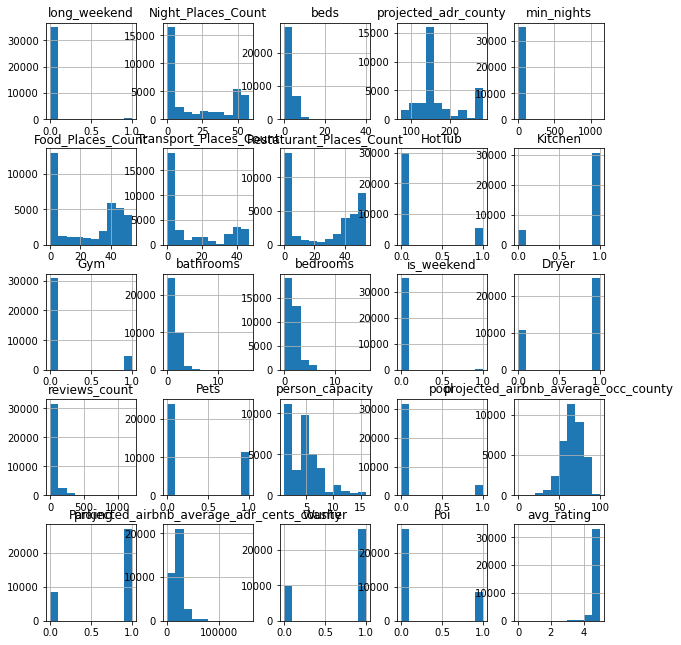

In [40]:
model_df[numerical_cols].hist(figsize=(10,11));

In [49]:
# Log transforming columns
# As we can see the distibution are skewed log transformation will help so doing it

for col in numerical_columns:
    model_df[col] = model_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    model_df[col] = np.log(model_df[col])
model_df

,zipcode_id,county_id,avg_rating,bathrooms,bedrooms,beds,person_capacity,reviews_count,room_type,space_type,...,Night_Places_Count,Poi,pool,Kitchen,Parking,Pets,Gym,HotTub,Washer,Dryer
0,41416,1517,3.76,1.5,3,7,6,17,Entire home/apt,Entire house,...,8,0,0,1,1,1,0,0,1,1
1,41450,1501,4.88,1.0,1,2,3,0,Entire home/apt,Entire serviced apartment,...,51,1,0,1,0,1,0,0,1,1
2,41430,1501,4.88,1.0,1,1,2,0,Entire home/apt,Entire rental unit,...,53,1,0,1,0,0,1,0,1,0
3,41450,1501,4.88,1.0,0,1,2,0,Entire home/apt,Entire serviced apartment,...,51,1,0,1,0,1,1,0,1,1
4,41539,2530,4.81,1.0,2,3,4,27,Entire home/apt,Entire cottage,...,0,0,0,1,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35510,41388,1501,4.82,2.0,4,5,10,11,Entire home/apt,Entire home,...,19,0,0,1,1,0,0,0,1,1
35511,41394,1501,4.91,3.0,4,5,10,11,Entire home/apt,Entire home,...,24,1,0,1,1,0,1,0,1,1
35512,41617,1642,4.93,1.0,1,3,4,86,Entire home/apt,Entire cabin,...,0,0,0,1,1,0,0,0,0,0
35513,41369,1501,4.88,1.0,1,1,2,1,Private room,Private room,...,33,0,0,1,1,0,0,0,1,1


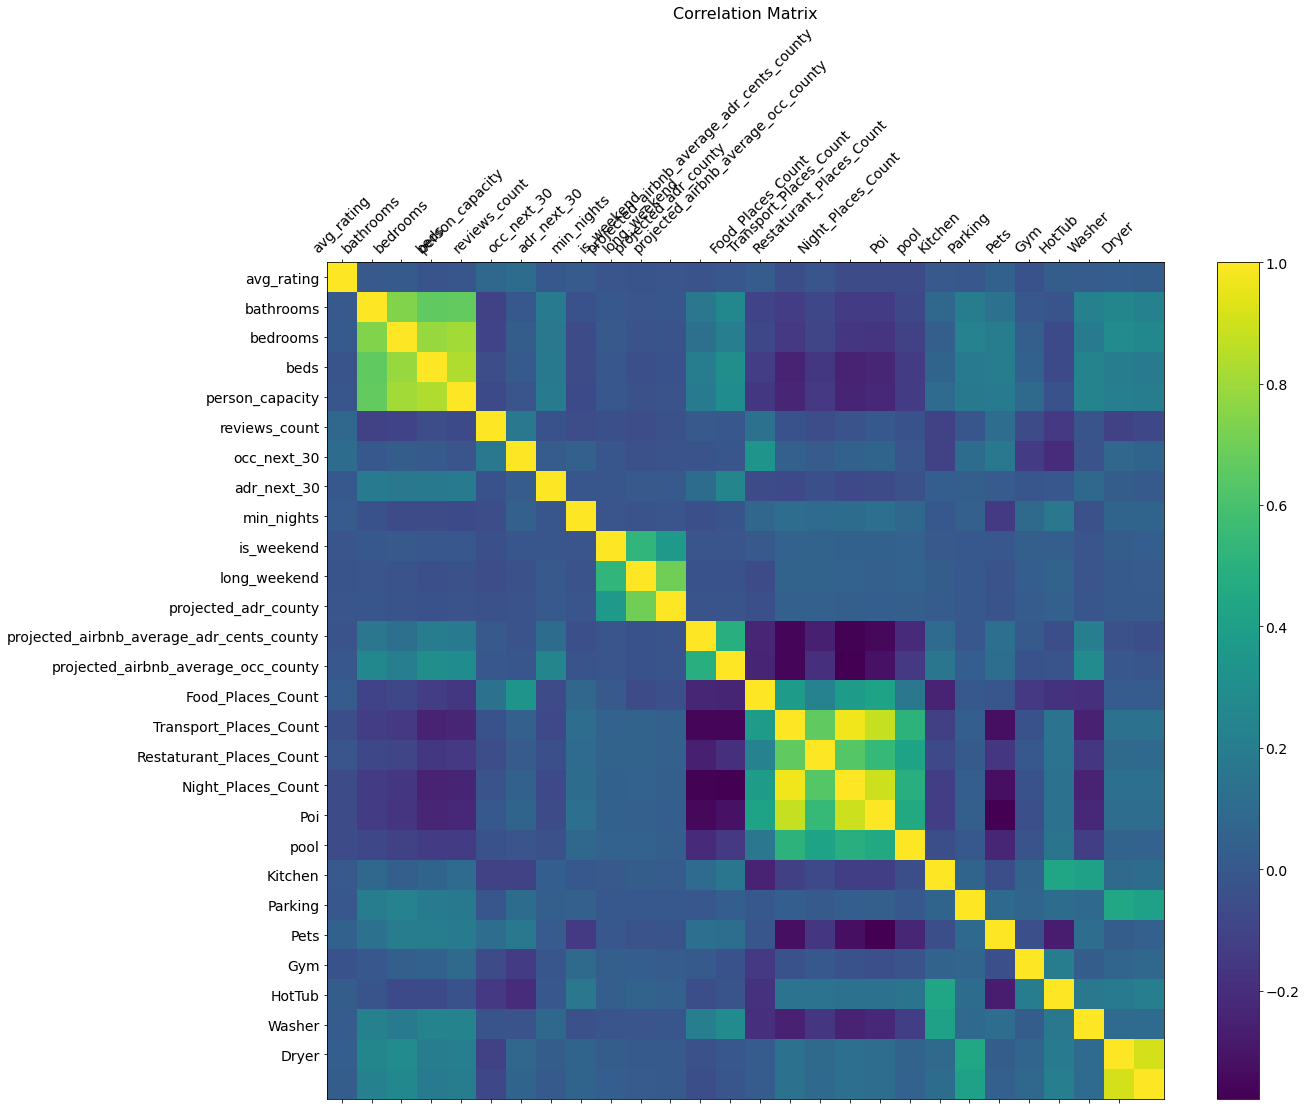

In [48]:
# Correlation heat map which helps in understanding the columns which are highly correlated
# We will drop one the column which is correlted to other so that there wont be any bias on the modelling side
f = plt.figure(figsize=(19, 15))
plt.matshow(model_df.corr(), fignum=f.number)
plt.xticks(range(model_df.select_dtypes(['number']).shape[1]), model_df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(model_df.select_dtypes(['number']).shape[1]), model_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [49]:
model_df_onehot

,avg_rating,bathrooms,bedrooms,beds,person_capacity,reviews_count,occ_next_30,adr_next_30,min_nights,is_weekend,...,Shared room,Shipping container,Tent,Tiny home,Tiny house,Tipi,Tower,Train,Treehouse,Yurt
0,3.76,1.5,3,7,6,17,100,271,2,0,...,0,0,0,0,0,0,0,0,0,0
1,4.88,1.0,1,2,3,0,0,60,2,0,...,0,0,0,0,0,0,0,0,0,0
2,4.88,1.0,1,1,2,0,100,150,2,0,...,0,0,0,0,0,0,0,0,0,0
3,4.88,1.0,0,1,2,0,0,49,2,0,...,0,0,0,0,0,0,0,0,0,0
4,4.81,1.0,2,3,4,27,100,216,2,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35510,4.82,2.0,4,5,10,11,100,556,2,0,...,0,0,0,0,0,0,0,0,0,0
35511,4.91,3.0,4,5,10,11,87,490,2,0,...,0,0,0,0,0,0,0,0,0,0
35512,4.93,1.0,1,3,4,86,60,158,3,0,...,0,0,0,0,0,0,0,0,0,0
35513,4.88,1.0,1,1,2,1,3,89,2,0,...,0,0,0,0,0,0,0,0,0,0


In [317]:
# handling the categorical values:
# One Hot Encoding the categorical columns
model_df_onehot = pd.get_dummies(model_df, prefix = "", prefix_sep = "")


In [117]:
# adding additional columns for the test dataset so it doesnt fail because of missing columns obtained from one hot encodin
additional_cols = list(set(model_df_onehot.columns) - set(test_df_onehot.columns))                 
d = dict.fromkeys(additional_cols, 0)
test_df_onehot = test_df_onehot.assign(**d)

/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_onehot = test_df_onehot.assign(**d)
/var/folders/42/bb36ymy50459qcxy7dcczcf40000gn/T/ipykernel_38345/2784753383.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

In [318]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

# Separating X and y
X_adr = model_df_onehot.drop(['adr_next_30', 'occ_next_30'], axis=1)
X_adr = X_adr.loc[:,~X_adr.columns.duplicated()]
test_adr = test_adr.loc[:,~test_adr.columns.duplicated()]
y_adr = model_df_onehot.adr_next_30


# Scaling
scaler = StandardScaler()
X_adr = pd.DataFrame(scaler.fit_transform(X_adr), columns=list(X_adr.columns))



In [319]:
# getting the main test df as a differnt dataframe
test_adr = X_adr.tail(7).drop(["test", "train"], axis = 1)
X_adr =X_adr.head(-7).drop(["test", "train"], axis = 1)
y_adr = y_adr.head(-7)

In [320]:

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_adr, y_adr, test_size=0.2, random_state=123) 


# Create instance of the model, `LinearRegression` function from 
# Scikit-Learn and fit the model on the training data:

hpm_reg = LinearRegression()  
hpm_reg.fit(X_train, y_train) #training the algorithm

# Now that the model has been fit we can make predictions by calling 
# the predict command. We are making predictions on the testing set:

training_preds_hpm_reg = hpm_reg.predict(X_train)
val_preds_hpm_reg = hpm_reg.predict(X_test)


# Check the predictions against the actual values by using the MSE and R-2 metrics:
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_hpm_reg),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_hpm_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_hpm_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_hpm_reg),4))


Training RMSE: 455250.6963
Validation RMSE: 2.7460595516226377e+31

Training r2: 0.1557
Validation r2: -6.848936495284446e+25


In [ ]:
# Grid search 
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRFRegressor
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [7, 10, 15, 25],
        'min_child_weight': [1, 3, 15],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5 ,0.7],
        'n_estimators' : [100, 200, 250, 300],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           scoring = 'neg_mean_absolute_error', #MAE
                           scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

hyperParameterTuning(X_train, y_train)

In [321]:
import time
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor(colsample_bytree = 0.5,
 learning_rate = 0.01,
 max_depth =  18,
 min_child_weight = 1,
 n_estimators = 200,
 objective = 'reg:squarederror',
 subsample = 0.5)
xgb_reg.fit(X_adr, y_adr)
training_preds_xgb_reg = xgb_reg.predict(X_adr)
# val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_adr, training_preds_xgb_reg),4))
# print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
# print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
# print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 1.0 minutes

Training MSE: 133629.5374


In [322]:
# final predictions being mafe
xgb_reg.predict(test_adr)


array([292.56396, 292.94708, 148.63087, 149.66858, 155.53738, 145.8096 ,
       146.48488], dtype=float32)

In [26]:
import time
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))




Time taken to run: 0.0 minutes

Training MSE: 188292.0166
Validation MSE: 373902.688

Training r2: 0.6508
Validation r2: 0.0675


In [27]:
# Feature importance
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg.head(10)

,weight
reviews_count,0.166153
bathrooms,0.157066
zipcode_id,0.142914
Entire home/apt,0.129067
bedrooms,0.126297
beds,0.109677
person_capacity,0.077204
Hotel room,0.076491
Private room,0.014149
Shared room,0.000981


In [324]:
# OCC modeling
X_occ = model_df_onehot.drop(['adr_next_30', 'occ_next_30'], axis=1)
X_occ = X_occ.loc[:,~X_occ.columns.duplicated()]
y_occ = model_df_onehot.occ_next_30

# Scaling
scaler = StandardScaler()
X_occ = pd.DataFrame(scaler.fit_transform(X_occ), columns=list(X_occ.columns))




# getting the main test df as a differnt dataframe
test_occ = X_occ.tail(7).drop(["test", "train"], axis = 1)
X_occ =X_occ.head(-7).drop(["test", "train"], axis = 1)
y_occ = y_occ.head(-7)

In [300]:
# Splitting into train and test sets
X_train_occ, X_test_occ, y_train_occ, y_test_occ = train_test_split(X_occ, y_occ, test_size=0.1, random_state=123) 




In [82]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRFRegressor
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.05, 0.5],
        'max_depth': [7, 10, 15, 25],
        'min_child_weight': [1, 5, 15],
        'subsample': [0.5, 0.75],
        'colsample_bytree': [0.5, 0.75],
        'n_estimators' : [100, 200, 300],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           scoring = 'neg_mean_absolute_error', #MAE
                           scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

hyperParameterTuning(X_train_occ, y_train_occ)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


{'colsample_bytree': 0.5,
 'learning_rate': 0.05,
 'max_depth': 15,
 'min_child_weight': 1,
 'n_estimators': 200,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

In [325]:
import time
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor(max_depth = 8)
xgb_reg.fit(X_occ, y_occ)
training_preds_xgb_reg = xgb_reg.predict(X_occ)
# val_preds_xgb_reg = xgb_reg.predict(X_occ)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_occ, training_preds_xgb_reg),4))





Time taken to run: 0.5 minutes

Training MSE: 532.6402


In [143]:
y_test_array = np.array(list(y_test_occ))
val_preds_hpm_reg_array = np.array(val_preds_xgb_reg)
hpm_df = pd.DataFrame({'Actual': y_test_array.flatten(), 'Predicted': val_preds_hpm_reg_array.flatten()})
hpm_df

,Actual,Predicted
0,90,83.226891
1,100,92.989212
2,0,7.189989
3,0,-1.516338
4,60,75.203995
...,...,...
3547,60,59.195789
3548,87,86.292404
3549,100,89.056915
3550,40,60.083790


In [303]:
# final occ predictions
xgb_reg.predict(test_occ)

array([73.962425, 73.962425, 69.07737 , 71.47975 , 67.20584 , 69.42595 ,
       68.20903 ], dtype=float32)

In [326]:
xgb_reg.predict(test_occ)

array([73.962425, 73.962425, 68.05413 , 74.500206, 67.48208 , 69.70219 ,
       68.48527 ], dtype=float32)

In [211]:
# Random Forest Regression Model
import time
xgb_reg_start = time.time()

from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(max_depth=16 ,  n_estimators = 50)
rf_reg.fit(X_occ, y_occ) 
rf_reg.predict(X_occ)
# val_preds_xgb_reg = xgb_reg.predict(X_occ)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_occ, training_preds_xgb_reg),4))
# print("Validation MSE:", round(mean_squared_error(y_test_occ, val_preds_xgb_reg),4))
# print("\nTraining r2:", round(r2_score(y_train_occ, training_preds_xgb_reg),4))
# print("Validation r2:", round(r2_score(y_test_occ, val_preds_xgb_reg),4))






Time taken to run: 0.7 minutes

Training MSE: 538.2069


In [213]:
rf_reg.predict(test_occ)

array([65.01702385])

In [204]:
rf_reg.predict(test_adr)

array([203.09166595])

In [203]:
rf_reg = RandomForestRegressor(max_depth=16 ,  n_estimators = 100)
rf_reg.fit(X_adr, y_adr) 


RandomForestRegressor(max_depth=16)

In [144]:
# Important features
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train_occ.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg.head(10)

,weight
Entire serviced apartment,0.678017
Entire apartment,0.020984
Campsite,0.012747
Entire condominium,0.011514
Hotel room,0.011261
Entire house,0.010647
Room in boutique hotel,0.009963
projected_airbnb_average_occ_county,0.009564
Tiny house,0.008511
Tent,0.007547


In [214]:
import math
import matplotlib.pyplot as plt
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
#     # Line graph of losses
#     model_results = model.history.history
#     plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
#     plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
#     plt.legend()
#     plt.title('Training and test loss at each epoch', fontsize=14)
#     plt.show()
    
#     # Scatterplot of predicted vs. actual values
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
#     fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
#     plt.subplots_adjust(top=0.93, wspace=0)
    
#     ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
#     ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
#     ax1.set_title('Test set')
#     ax1.set_xlabel('Actual values')
#     ax1.set_ylabel('Predicted values')
    
#     ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
#     ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
#     ax2.set_title('Train set')
#     ax2.set_xlabel('Actual values')
#     ax2.set_ylabel('')
#     ax2.set_yticklabels(labels='')
    
#     plt.show()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               79360     
                                                                 
 dense_13 (Dense)            (None, 256)               33024     
                                                                 
 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 178,433
Trainable params: 178,433
Non-trainable params: 0
_________________________________________________________________
None


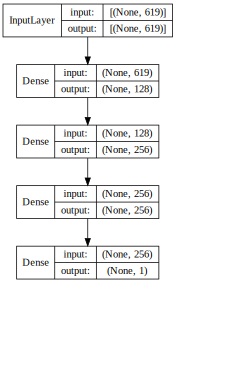

In [215]:
# Building the model
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn2.summary())

# Visualising the neural network
SVG(model_to_dot(nn2, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Epoch 1/100
138/138 [==============================] - 0s 3ms/step - loss: 13812.6445 - mean_squared_error: 13812.6445 - val_loss: 23675.9277 - val_mean_squared_error: 23675.9277
Epoch 2/100
138/138 [==============================] - 0s 3ms/step - loss: 19314.0566 - mean_squared_error: 19314.0566 - val_loss: 26202.7754 - val_mean_squared_error: 26202.7754
Epoch 3/100
138/138 [==============================] - 0s 3ms/step - loss: 16411.3711 - mean_squared_error: 16411.3711 - val_loss: 31029.1133 - val_mean_squared_error: 31029.1133
Epoch 4/100
138/138 [==============================] - 0s 3ms/step - loss: 20558.2617 - mean_squared_error: 20558.2617 - val_loss: 25560.0527 - val_mean_squared_error: 25560.0527
Epoch 5/100
138/138 [==============================] - 0s 3ms/step - loss: 12255.1270 - mean_squared_error: 12255.1270 - val_loss: 28011.5566 - val_mean_squared_error: 28011.5566
Epoch 6/100
138/138 [==============================] - 0s 3ms/step - loss: 11148.4053 - mean_squared_erro

138/138 [==============================] - 0s 3ms/step - loss: 11353.3418 - mean_squared_error: 11353.3418 - val_loss: 31506.7188 - val_mean_squared_error: 31506.7188
Epoch 47/100
138/138 [==============================] - 0s 3ms/step - loss: 11226.0410 - mean_squared_error: 11226.0410 - val_loss: 35418.5352 - val_mean_squared_error: 35418.5352
Epoch 48/100
138/138 [==============================] - 0s 3ms/step - loss: 12518.4912 - mean_squared_error: 12518.4912 - val_loss: 33050.2148 - val_mean_squared_error: 33050.2148
Epoch 49/100
138/138 [==============================] - 0s 3ms/step - loss: 11312.3799 - mean_squared_error: 11312.3799 - val_loss: 38247.9258 - val_mean_squared_error: 38247.9258
Epoch 50/100
138/138 [==============================] - 0s 3ms/step - loss: 10805.0312 - mean_squared_error: 10805.0312 - val_loss: 35591.0625 - val_mean_squared_error: 35591.0625
Epoch 51/100
138/138 [==============================] - 0s 4ms/step - loss: 11413.7803 - mean_squared_error: 1141

138/138 [==============================] - 0s 3ms/step - loss: 11131.1250 - mean_squared_error: 11131.1250 - val_loss: 38113.3164 - val_mean_squared_error: 38113.3164
Epoch 92/100
138/138 [==============================] - 0s 3ms/step - loss: 21400.2051 - mean_squared_error: 21400.2051 - val_loss: 30344.4316 - val_mean_squared_error: 30344.4316
Epoch 93/100
138/138 [==============================] - 0s 3ms/step - loss: 18470.1660 - mean_squared_error: 18470.1660 - val_loss: 38297.7539 - val_mean_squared_error: 38297.7539
Epoch 94/100
138/138 [==============================] - 0s 3ms/step - loss: 12766.3887 - mean_squared_error: 12766.3887 - val_loss: 30677.3008 - val_mean_squared_error: 30677.3008
Epoch 95/100
138/138 [==============================] - 0s 3ms/step - loss: 12991.3770 - mean_squared_error: 12991.3770 - val_loss: 28502.6172 - val_mean_squared_error: 28502.6172
Epoch 96/100
138/138 [==============================] - 0s 3ms/step - loss: 12750.8740 - mean_squared_error: 1275

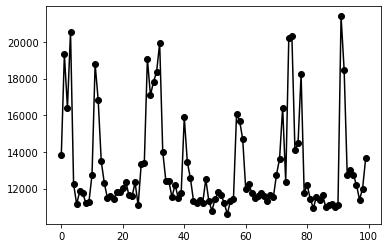

In [249]:
# Training the model
nn2_start = time.time()

nn2_history = nn2.fit(X_adr,
                  y_adr,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.01,
                     verbose = 1)
plt.plot(list(nn2_history.history.values())[0],'k-o')

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")

In [250]:
nn2.predict(test_adr)

1/1 [==============================] - 0s 13ms/step


array([[255.49797]], dtype=float32)

Epoch 1/200
84/84 [==============================] - 0s 5ms/step - loss: 27282.3750 - mean_squared_error: 27282.3750 - val_loss: 7749.3032 - val_mean_squared_error: 7749.3032
Epoch 2/200
84/84 [==============================] - 0s 4ms/step - loss: 23279.0254 - mean_squared_error: 23279.0254 - val_loss: 8195.9326 - val_mean_squared_error: 8195.9326
Epoch 3/200
84/84 [==============================] - 0s 4ms/step - loss: 20690.3652 - mean_squared_error: 20690.3652 - val_loss: 6724.7637 - val_mean_squared_error: 6724.7637
Epoch 4/200
84/84 [==============================] - 0s 4ms/step - loss: 20896.4707 - mean_squared_error: 20896.4707 - val_loss: 6360.1826 - val_mean_squared_error: 6360.1826
Epoch 5/200
84/84 [==============================] - 0s 4ms/step - loss: 22183.9707 - mean_squared_error: 22183.9707 - val_loss: 6534.1260 - val_mean_squared_error: 6534.1260
Epoch 6/200
84/84 [==============================] - 0s 4ms/step - loss: 18042.5234 - mean_squared_error: 18042.5234 - val_lo

84/84 [==============================] - 0s 4ms/step - loss: 24444.6172 - mean_squared_error: 24444.6172 - val_loss: 8155.1279 - val_mean_squared_error: 8155.1279
Epoch 48/200
84/84 [==============================] - 0s 4ms/step - loss: 20763.6270 - mean_squared_error: 20763.6270 - val_loss: 8266.6104 - val_mean_squared_error: 8266.6104
Epoch 49/200
84/84 [==============================] - 0s 4ms/step - loss: 18299.4258 - mean_squared_error: 18299.4258 - val_loss: 7606.5938 - val_mean_squared_error: 7606.5938
Epoch 50/200
84/84 [==============================] - 0s 4ms/step - loss: 17305.7441 - mean_squared_error: 17305.7441 - val_loss: 7297.6299 - val_mean_squared_error: 7297.6299
Epoch 51/200
84/84 [==============================] - 0s 4ms/step - loss: 17832.3574 - mean_squared_error: 17832.3574 - val_loss: 8416.4727 - val_mean_squared_error: 8416.4727
Epoch 52/200
84/84 [==============================] - 0s 4ms/step - loss: 16154.6016 - mean_squared_error: 16154.6016 - val_loss: 737

84/84 [==============================] - 0s 4ms/step - loss: 19784.4023 - mean_squared_error: 19784.4023 - val_loss: 10118.9316 - val_mean_squared_error: 10118.9316
Epoch 94/200
84/84 [==============================] - 0s 4ms/step - loss: 18194.0566 - mean_squared_error: 18194.0566 - val_loss: 8956.9277 - val_mean_squared_error: 8956.9277
Epoch 95/200
84/84 [==============================] - 0s 4ms/step - loss: 16022.7852 - mean_squared_error: 16022.7852 - val_loss: 9044.3281 - val_mean_squared_error: 9044.3281
Epoch 96/200
84/84 [==============================] - 0s 4ms/step - loss: 16297.0449 - mean_squared_error: 16297.0449 - val_loss: 8283.9502 - val_mean_squared_error: 8283.9502
Epoch 97/200
84/84 [==============================] - 0s 4ms/step - loss: 20745.1387 - mean_squared_error: 20745.1387 - val_loss: 8871.2812 - val_mean_squared_error: 8871.2812
Epoch 98/200
84/84 [==============================] - 0s 4ms/step - loss: 18276.6797 - mean_squared_error: 18276.6797 - val_loss: 9

84/84 [==============================] - 0s 4ms/step - loss: 20672.9648 - mean_squared_error: 20672.9648 - val_loss: 10161.1670 - val_mean_squared_error: 10161.1670
Epoch 140/200
84/84 [==============================] - 0s 4ms/step - loss: 21077.4746 - mean_squared_error: 21077.4746 - val_loss: 10857.6826 - val_mean_squared_error: 10857.6826
Epoch 141/200
84/84 [==============================] - 0s 4ms/step - loss: 18976.6719 - mean_squared_error: 18976.6719 - val_loss: 11476.8242 - val_mean_squared_error: 11476.8242
Epoch 142/200
84/84 [==============================] - 0s 4ms/step - loss: 17009.1523 - mean_squared_error: 17009.1523 - val_loss: 11323.1650 - val_mean_squared_error: 11323.1650
Epoch 143/200
84/84 [==============================] - 0s 4ms/step - loss: 17764.4980 - mean_squared_error: 17764.4980 - val_loss: 10847.3672 - val_mean_squared_error: 10847.3672
Epoch 144/200
84/84 [==============================] - 0s 4ms/step - loss: 21201.7969 - mean_squared_error: 21201.7969 

Epoch 185/200
84/84 [==============================] - 0s 4ms/step - loss: 15471.3877 - mean_squared_error: 15471.3877 - val_loss: 11360.9434 - val_mean_squared_error: 11360.9434
Epoch 186/200
84/84 [==============================] - 0s 4ms/step - loss: 15890.5518 - mean_squared_error: 15890.5518 - val_loss: 12155.6523 - val_mean_squared_error: 12155.6523
Epoch 187/200
84/84 [==============================] - 0s 4ms/step - loss: 17416.3379 - mean_squared_error: 17416.3379 - val_loss: 12036.9082 - val_mean_squared_error: 12036.9082
Epoch 188/200
84/84 [==============================] - 0s 4ms/step - loss: 16414.6094 - mean_squared_error: 16414.6094 - val_loss: 11239.3848 - val_mean_squared_error: 11239.3848
Epoch 189/200
84/84 [==============================] - 0s 4ms/step - loss: 15991.7539 - mean_squared_error: 15991.7539 - val_loss: 11619.3408 - val_mean_squared_error: 11619.3408
Epoch 190/200
84/84 [==============================] - 0s 4ms/step - loss: 21535.7441 - mean_squared_erro

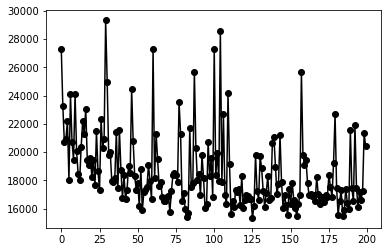

In [255]:
# Training the model
nn2_start = time.time()

nn2_history = nn2.fit(X_adr,
                  y_adr,
                  epochs=200,
                  batch_size=256,
                  validation_split = 0.4,
                     verbose = 1)
plt.plot(list(nn2_history.history.values())[0],'k-o')

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")

In [257]:
nn2.predict(test_adr)

1/1 [==============================] - 0s 13ms/step


array([[297.47583]], dtype=float32)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               79360     
                                                                 
 dense_17 (Dense)            (None, 256)               33024     
                                                                 
 dense_18 (Dense)            (None, 256)               65792     
                                                                 
 dense_19 (Dense)            (None, 512)               131584    
                                                                 
 dense_20 (Dense)            (None, 1)                 513       
                                                                 
Total params: 310,273
Trainable params: 310,273
Non-trainable params: 0
_________________________________________________________________
None


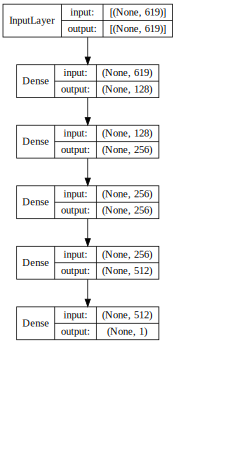

In [219]:
# Building the model
nn3 = models.Sequential()
nn3.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn3.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn3.summary())

# Visualising the neural network
SVG(model_to_dot(nn3, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [266]:
# Training the model
nn3_start = time.time()

nn3_history = nn3.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=256,
                  validation_split = 0.1)

nn3_end = time.time()

print(f"Time taken to run: {round((nn3_end - nn3_start)/60,1)} minutes")

Epoch 1/50
100/100 [==============================] - 1s 5ms/step - loss: 26818.3535 - mean_squared_error: 26726.8633 - val_loss: 77728.3359 - val_mean_squared_error: 77636.8438
Epoch 2/50
100/100 [==============================] - 0s 4ms/step - loss: 23956.2285 - mean_squared_error: 23864.6680 - val_loss: 77014.7109 - val_mean_squared_error: 76923.1953
Epoch 3/50
100/100 [==============================] - 0s 5ms/step - loss: 24488.0391 - mean_squared_error: 24396.5000 - val_loss: 87226.7734 - val_mean_squared_error: 87135.1719
Epoch 4/50
100/100 [==============================] - 0s 5ms/step - loss: 24436.2383 - mean_squared_error: 24344.4941 - val_loss: 70447.3906 - val_mean_squared_error: 70355.5859
Epoch 5/50
100/100 [==============================] - 1s 5ms/step - loss: 25082.2539 - mean_squared_error: 24990.5762 - val_loss: 76712.4453 - val_mean_squared_error: 76620.7500
Epoch 6/50
100/100 [==============================] - 1s 6ms/step - loss: 22738.6211 - mean_squared_error: 226

Epoch 47/50
100/100 [==============================] - 0s 4ms/step - loss: 23820.8984 - mean_squared_error: 23726.0059 - val_loss: 72812.5000 - val_mean_squared_error: 72717.7266
Epoch 48/50
100/100 [==============================] - 0s 4ms/step - loss: 24296.3965 - mean_squared_error: 24201.5996 - val_loss: 70274.4453 - val_mean_squared_error: 70179.4766
Epoch 49/50
100/100 [==============================] - 0s 4ms/step - loss: 24524.8047 - mean_squared_error: 24429.9062 - val_loss: 99504.7578 - val_mean_squared_error: 99409.5859
Epoch 50/50
100/100 [==============================] - 0s 4ms/step - loss: 24510.0820 - mean_squared_error: 24414.8496 - val_loss: 89168.3125 - val_mean_squared_error: 89073.2812
Time taken to run: 0.4 minutes


In [267]:
# Evaluating the model
# nn_model_evaluation(nn3, skip_epochs=2)
nn3.predict(test_adr)


1/1 [==============================] - 0s 14ms/step


array([[361.21585]], dtype=float32)

In [224]:
# Training the model
nn3_occ_start = time.time()
# Building the model
nn3_occ = models.Sequential()
nn3_occ.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3_occ.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3_occ.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3_occ.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3_occ.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn3_occ.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn3.summary())

# Visualising the neural network
SVG(model_to_dot(nn3, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))
nn3_occ_history = nn3.fit(X_occ,
                  y_occ,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

nn3_occ_end = time.time()

print(f"Time taken to run: {round((nn3_end - nn3_start)/60,1)} minutes")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               79360     
                                                                 
 dense_17 (Dense)            (None, 256)               33024     
                                                                 
 dense_18 (Dense)            (None, 256)               65792     
                                                                 
 dense_19 (Dense)            (None, 512)               131584    
                                                                 
 dense_20 (Dense)            (None, 1)                 513       
                                                                 
Total params: 310,273
Trainable params: 310,273
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
125/125 [======================

Epoch 42/150
125/125 [==============================] - 1s 5ms/step - loss: 734.0773 - mean_squared_error: 634.9963 - val_loss: 1045.5332 - val_mean_squared_error: 946.5524
Epoch 43/150
125/125 [==============================] - 1s 5ms/step - loss: 724.4783 - mean_squared_error: 625.5847 - val_loss: 1057.5729 - val_mean_squared_error: 958.7524
Epoch 44/150
125/125 [==============================] - 1s 5ms/step - loss: 718.5527 - mean_squared_error: 619.8297 - val_loss: 1063.9757 - val_mean_squared_error: 965.3525
Epoch 45/150
125/125 [==============================] - 1s 5ms/step - loss: 711.3747 - mean_squared_error: 612.8546 - val_loss: 1065.3977 - val_mean_squared_error: 966.9527
Epoch 46/150
125/125 [==============================] - 1s 5ms/step - loss: 701.2525 - mean_squared_error: 602.9288 - val_loss: 1067.0662 - val_mean_squared_error: 968.8442
Epoch 47/150
125/125 [==============================] - 1s 5ms/step - loss: 694.0939 - mean_squared_error: 595.9751 - val_loss: 1065.67

125/125 [==============================] - 1s 6ms/step - loss: 472.1294 - mean_squared_error: 393.6434 - val_loss: 1155.0939 - val_mean_squared_error: 1077.0062
Epoch 90/150
125/125 [==============================] - 1s 4ms/step - loss: 468.1582 - mean_squared_error: 390.4703 - val_loss: 1186.7329 - val_mean_squared_error: 1109.4569
Epoch 91/150
125/125 [==============================] - 1s 5ms/step - loss: 465.4280 - mean_squared_error: 388.5310 - val_loss: 1175.3457 - val_mean_squared_error: 1098.7434
Epoch 92/150
125/125 [==============================] - 1s 4ms/step - loss: 464.0981 - mean_squared_error: 387.9146 - val_loss: 1168.6201 - val_mean_squared_error: 1092.8866
Epoch 93/150
125/125 [==============================] - 1s 4ms/step - loss: 459.7753 - mean_squared_error: 384.2719 - val_loss: 1219.1183 - val_mean_squared_error: 1143.8108
Epoch 94/150
125/125 [==============================] - 1s 5ms/step - loss: 454.5080 - mean_squared_error: 379.7036 - val_loss: 1169.8743 - val

Epoch 136/150
125/125 [==============================] - 1s 4ms/step - loss: 329.7454 - mean_squared_error: 278.8274 - val_loss: 1218.9954 - val_mean_squared_error: 1168.1083
Epoch 137/150
125/125 [==============================] - 1s 5ms/step - loss: 325.4374 - mean_squared_error: 274.6407 - val_loss: 1220.9301 - val_mean_squared_error: 1170.1927
Epoch 138/150
125/125 [==============================] - 1s 5ms/step - loss: 325.8539 - mean_squared_error: 275.1589 - val_loss: 1224.6974 - val_mean_squared_error: 1174.0671
Epoch 139/150
125/125 [==============================] - 1s 5ms/step - loss: 323.5363 - mean_squared_error: 272.9991 - val_loss: 1208.5172 - val_mean_squared_error: 1158.1064
Epoch 140/150
125/125 [==============================] - 1s 5ms/step - loss: 323.2856 - mean_squared_error: 272.9533 - val_loss: 1241.8538 - val_mean_squared_error: 1191.4565
Epoch 141/150
125/125 [==============================] - 1s 5ms/step - loss: 324.3522 - mean_squared_error: 273.9793 - val_lo

In [227]:
nn3.predict(test_occ)

1/1 [==============================] - 0s 15ms/step


array([[86.5205]], dtype=float32)

In [327]:
nn3.predict(test_occ)

1/1 [==============================] - 0s 62ms/step


array([[359.30978],
       [362.09955],
       [302.4542 ],
       [316.69354],
       [307.35425],
       [287.2674 ],
       [285.47955]], dtype=float32)

Epoch 1/100
138/138 [==============================] - 1s 3ms/step - loss: 516587.6250 - mean_squared_error: 516587.6250 - val_loss: 20000.1953 - val_mean_squared_error: 20000.1953
Epoch 2/100
138/138 [==============================] - 0s 2ms/step - loss: 495734.7812 - mean_squared_error: 495734.7812 - val_loss: 20099.3477 - val_mean_squared_error: 20099.3477
Epoch 3/100
138/138 [==============================] - 0s 2ms/step - loss: 494751.4688 - mean_squared_error: 494751.4688 - val_loss: 19340.9805 - val_mean_squared_error: 19340.9805
Epoch 4/100
138/138 [==============================] - 0s 2ms/step - loss: 494429.1562 - mean_squared_error: 494429.1562 - val_loss: 19790.0898 - val_mean_squared_error: 19790.0898
Epoch 5/100
138/138 [==============================] - 0s 2ms/step - loss: 494006.5625 - mean_squared_error: 494006.5625 - val_loss: 20065.8281 - val_mean_squared_error: 20065.8281
Epoch 6/100
138/138 [==============================] - 0s 2ms/step - loss: 493658.1250 - mean_s

138/138 [==============================] - 0s 2ms/step - loss: 489773.5625 - mean_squared_error: 489773.5625 - val_loss: 19918.2266 - val_mean_squared_error: 19918.2266
Epoch 47/100
138/138 [==============================] - 0s 2ms/step - loss: 489928.9062 - mean_squared_error: 489928.9062 - val_loss: 21411.4277 - val_mean_squared_error: 21411.4277
Epoch 48/100
138/138 [==============================] - 0s 2ms/step - loss: 489810.1875 - mean_squared_error: 489810.1875 - val_loss: 21403.6289 - val_mean_squared_error: 21403.6289
Epoch 49/100
138/138 [==============================] - 0s 2ms/step - loss: 489372.6250 - mean_squared_error: 489372.6250 - val_loss: 20447.5117 - val_mean_squared_error: 20447.5117
Epoch 50/100
138/138 [==============================] - 0s 2ms/step - loss: 489246.4062 - mean_squared_error: 489246.4062 - val_loss: 24258.0137 - val_mean_squared_error: 24258.0176
Epoch 51/100
138/138 [==============================] - 0s 2ms/step - loss: 489433.0312 - mean_squared_

138/138 [==============================] - 0s 2ms/step - loss: 482155.0938 - mean_squared_error: 482155.0938 - val_loss: 32644.8398 - val_mean_squared_error: 32644.8398
Epoch 92/100
138/138 [==============================] - 0s 2ms/step - loss: 484271.0000 - mean_squared_error: 484271.0000 - val_loss: 26959.1680 - val_mean_squared_error: 26959.1680
Epoch 93/100
138/138 [==============================] - 0s 2ms/step - loss: 482841.1250 - mean_squared_error: 482841.1250 - val_loss: 29600.3770 - val_mean_squared_error: 29600.3770
Epoch 94/100
138/138 [==============================] - 0s 2ms/step - loss: 482706.8750 - mean_squared_error: 482706.8750 - val_loss: 28658.7129 - val_mean_squared_error: 28658.7129
Epoch 95/100
138/138 [==============================] - 0s 2ms/step - loss: 482473.1250 - mean_squared_error: 482473.1250 - val_loss: 25216.9727 - val_mean_squared_error: 25216.9727
Epoch 96/100
138/138 [==============================] - 0s 2ms/step - loss: 482542.5000 - mean_squared_

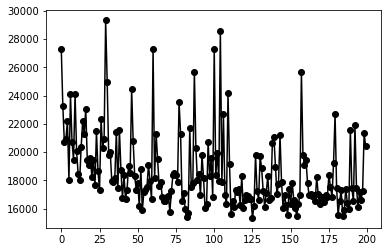

In [271]:
# Training the model
nn1_raw_data_start = time.time()
nn1_raw_data = models.Sequential()
nn1_raw_data.add(layers.Dense(128, input_shape=(X_adr[["avg_rating", "bathrooms", "bedrooms", "beds", "person_capacity", "min_nights"]].shape[1],), activation='relu'))
nn1_raw_data.add(layers.Dense(256, activation='relu'))
nn1_raw_data.add(layers.Dense(256, activation='relu'))
nn1_raw_data.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn1_raw_data.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

nn1_raw_data_history = nn1_raw_data.fit(X_adr[["avg_rating", "bathrooms", "bedrooms", "beds", "person_capacity", "min_nights"]],
                  y_adr,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.01,
                     verbose = 1)
plt.plot(list(nn2_history.history.values())[0],'k-o')

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")

In [273]:
nn1_raw_data.predict(test_occ[["avg_rating", "bathrooms", "bedrooms", "beds", "person_capacity", "min_nights"]])

1/1 [==============================] - 0s 47ms/step


array([[146.8124]], dtype=float32)

Epoch 1/100
138/138 [==============================] - 1s 4ms/step - loss: 1542.4412 - mean_squared_error: 1542.4412 - val_loss: 901.5256 - val_mean_squared_error: 901.5256
Epoch 2/100
138/138 [==============================] - 0s 3ms/step - loss: 957.1689 - mean_squared_error: 957.1689 - val_loss: 790.8628 - val_mean_squared_error: 790.8628
Epoch 3/100
138/138 [==============================] - 0s 3ms/step - loss: 911.6012 - mean_squared_error: 911.6012 - val_loss: 754.1505 - val_mean_squared_error: 754.1505
Epoch 4/100
138/138 [==============================] - 0s 3ms/step - loss: 885.5245 - mean_squared_error: 885.5245 - val_loss: 793.4512 - val_mean_squared_error: 793.4512
Epoch 5/100
138/138 [==============================] - 0s 3ms/step - loss: 862.7821 - mean_squared_error: 862.7821 - val_loss: 783.3135 - val_mean_squared_error: 783.3135
Epoch 6/100
138/138 [==============================] - 1s 4ms/step - loss: 842.1763 - mean_squared_error: 842.1763 - val_loss: 783.5806 - val_m

138/138 [==============================] - 0s 3ms/step - loss: 376.1869 - mean_squared_error: 376.1869 - val_loss: 1217.2961 - val_mean_squared_error: 1217.2961
Epoch 49/100
138/138 [==============================] - 0s 3ms/step - loss: 370.0306 - mean_squared_error: 370.0306 - val_loss: 1163.5525 - val_mean_squared_error: 1163.5525
Epoch 50/100
138/138 [==============================] - 0s 3ms/step - loss: 365.0878 - mean_squared_error: 365.0878 - val_loss: 1172.2924 - val_mean_squared_error: 1172.2924
Epoch 51/100
138/138 [==============================] - 0s 3ms/step - loss: 363.7025 - mean_squared_error: 363.7025 - val_loss: 1222.0667 - val_mean_squared_error: 1222.0667
Epoch 52/100
138/138 [==============================] - 0s 3ms/step - loss: 355.3807 - mean_squared_error: 355.3807 - val_loss: 1269.4194 - val_mean_squared_error: 1269.4194
Epoch 53/100
138/138 [==============================] - 0s 3ms/step - loss: 348.0265 - mean_squared_error: 348.0265 - val_loss: 1324.8442 - val

138/138 [==============================] - 1s 5ms/step - loss: 214.3004 - mean_squared_error: 214.3004 - val_loss: 1803.8252 - val_mean_squared_error: 1803.8252
Epoch 96/100
138/138 [==============================] - 1s 4ms/step - loss: 214.5402 - mean_squared_error: 214.5402 - val_loss: 1572.1121 - val_mean_squared_error: 1572.1121
Epoch 97/100
138/138 [==============================] - 1s 4ms/step - loss: 214.1918 - mean_squared_error: 214.1918 - val_loss: 1605.4651 - val_mean_squared_error: 1605.4651
Epoch 98/100
138/138 [==============================] - 1s 4ms/step - loss: 212.2120 - mean_squared_error: 212.2120 - val_loss: 1546.9045 - val_mean_squared_error: 1546.9045
Epoch 99/100
138/138 [==============================] - 1s 4ms/step - loss: 206.4942 - mean_squared_error: 206.4942 - val_loss: 1408.6108 - val_mean_squared_error: 1408.6108
Epoch 100/100
138/138 [==============================] - 1s 4ms/step - loss: 208.7844 - mean_squared_error: 208.7844 - val_loss: 1635.2168 - va

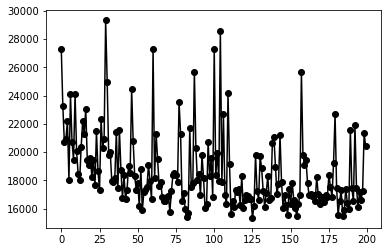

In [305]:
# Training the model
nn1_raw_data_start = time.time()
nn1_raw_data_occ = models.Sequential()
nn1_raw_data_occ.add(layers.Dense(128, input_shape=(X_adr[["avg_rating", "bathrooms", "bedrooms", "beds", "person_capacity", "min_nights"]].shape[1],), activation='relu'))
nn1_raw_data_occ.add(layers.Dense(256, activation='relu'))
nn1_raw_data_occ.add(layers.Dense(256, activation='relu'))
nn1_raw_data_occ.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn1_raw_data_occ.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

nn1_raw_data_history_occ = nn1_raw_data_occ.fit(X_adr[["avg_rating", "bathrooms", "bedrooms", "beds", "person_capacity", "min_nights"]],
                  y_occ,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.01,
                     verbose = 1)
plt.plot(list(nn2_history.history.values())[0],'k-o')

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")

In [275]:
nn1_raw_data_occ.predict(test_occ[["avg_rating", "bathrooms", "bedrooms", "beds", "person_capacity", "min_nights"]])



1/1 [==============================] - 0s 47ms/step


array([[42.247543]], dtype=float32)

In [309]:
# Training the model
nn3_occ_start = time.time()
# Building the model
nn3_occ1 = models.Sequential()
nn3_occ1.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3_occ1.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3_occ1.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3_occ1.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3_occ1.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn3_occ1.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

nn3_occ_history1 = nn3_occ1.fit(X_occ,
                  y_occ,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

nn3_occ_end = time.time()

print(f"Time taken to run: {round((nn3_end - nn3_start)/60,1)} minutes")

Epoch 1/150
125/125 [==============================] - 1s 6ms/step - loss: 1569.5658 - mean_squared_error: 1498.9854 - val_loss: 1019.1078 - val_mean_squared_error: 952.9173
Epoch 2/150
125/125 [==============================] - 1s 5ms/step - loss: 1020.2277 - mean_squared_error: 957.2233 - val_loss: 971.7031 - val_mean_squared_error: 911.4561
Epoch 3/150
125/125 [==============================] - 1s 7ms/step - loss: 971.0207 - mean_squared_error: 913.1635 - val_loss: 978.1057 - val_mean_squared_error: 922.3133
Epoch 4/150
125/125 [==============================] - 1s 7ms/step - loss: 935.7576 - mean_squared_error: 881.6838 - val_loss: 915.3068 - val_mean_squared_error: 862.7220
Epoch 5/150
125/125 [==============================] - 1s 6ms/step - loss: 909.1547 - mean_squared_error: 857.8213 - val_loss: 924.5425 - val_mean_squared_error: 874.3570
Epoch 6/150
125/125 [==============================] - 1s 5ms/step - loss: 884.9320 - mean_squared_error: 835.6063 - val_loss: 922.7518 - val

125/125 [==============================] - 1s 4ms/step - loss: 370.9679 - mean_squared_error: 329.5362 - val_loss: 1063.5952 - val_mean_squared_error: 1022.2216
Epoch 49/150
125/125 [==============================] - 1s 5ms/step - loss: 363.0238 - mean_squared_error: 321.6351 - val_loss: 1067.2386 - val_mean_squared_error: 1025.9103
Epoch 50/150
125/125 [==============================] - 1s 5ms/step - loss: 365.7464 - mean_squared_error: 324.3933 - val_loss: 1088.5011 - val_mean_squared_error: 1047.1595
Epoch 51/150
125/125 [==============================] - 1s 5ms/step - loss: 360.5821 - mean_squared_error: 319.2288 - val_loss: 1077.1736 - val_mean_squared_error: 1035.8721
Epoch 52/150
125/125 [==============================] - 1s 5ms/step - loss: 354.6210 - mean_squared_error: 313.2866 - val_loss: 1079.5090 - val_mean_squared_error: 1038.2488
Epoch 53/150
125/125 [==============================] - 1s 5ms/step - loss: 346.8915 - mean_squared_error: 305.6142 - val_loss: 1107.2649 - val

125/125 [==============================] - 1s 5ms/step - loss: 246.9138 - mean_squared_error: 205.8971 - val_loss: 1178.1981 - val_mean_squared_error: 1137.1714
Epoch 96/150
125/125 [==============================] - 1s 5ms/step - loss: 244.5546 - mean_squared_error: 203.5507 - val_loss: 1162.4680 - val_mean_squared_error: 1121.4271
Epoch 97/150
125/125 [==============================] - 1s 5ms/step - loss: 242.1756 - mean_squared_error: 201.1295 - val_loss: 1189.3068 - val_mean_squared_error: 1148.2260
Epoch 98/150
125/125 [==============================] - 1s 5ms/step - loss: 243.1735 - mean_squared_error: 202.1066 - val_loss: 1126.4478 - val_mean_squared_error: 1085.3445
Epoch 99/150
125/125 [==============================] - 1s 5ms/step - loss: 242.7652 - mean_squared_error: 201.6597 - val_loss: 1129.7228 - val_mean_squared_error: 1088.5876
Epoch 100/150
125/125 [==============================] - 1s 5ms/step - loss: 241.6073 - mean_squared_error: 200.4493 - val_loss: 1193.4290 - va

Epoch 142/150
125/125 [==============================] - 1s 5ms/step - loss: 199.6501 - mean_squared_error: 156.7009 - val_loss: 1190.0581 - val_mean_squared_error: 1147.0747
Epoch 143/150
125/125 [==============================] - 1s 5ms/step - loss: 196.6557 - mean_squared_error: 153.6828 - val_loss: 1205.6368 - val_mean_squared_error: 1162.6451
Epoch 144/150
125/125 [==============================] - 1s 5ms/step - loss: 199.8288 - mean_squared_error: 156.8158 - val_loss: 1202.4365 - val_mean_squared_error: 1159.3696
Epoch 145/150
125/125 [==============================] - 1s 6ms/step - loss: 198.4670 - mean_squared_error: 155.3907 - val_loss: 1200.4696 - val_mean_squared_error: 1157.3484
Epoch 146/150
125/125 [==============================] - 1s 5ms/step - loss: 193.5462 - mean_squared_error: 150.4273 - val_loss: 1175.3304 - val_mean_squared_error: 1132.2030
Epoch 147/150
125/125 [==============================] - 1s 5ms/step - loss: 195.0219 - mean_squared_error: 151.8776 - val_lo

In [311]:
nn3_occ1.predict(test_occ)

1/1 [==============================] - 0s 22ms/step


array([[42.55567 ],
       [42.366055],
       [42.11771 ],
       [44.702976],
       [43.95342 ],
       [42.375973],
       [42.464252]], dtype=float32)

In [312]:
# Training the model
nn3_occ_start = time.time()
# Building the model
nn3_adr1 = models.Sequential()
nn3_adr1.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3_adr1.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3_adr1.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3_adr1.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3_adr1.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn3_adr1.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

nn3_adr_history1 = nn3_adr1.fit(X_adr,
                  y_adr,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

nn3_occ_end = time.time()

print(f"Time taken to run: {round((nn3_end - nn3_start)/60,1)} minutes")

Epoch 1/150
125/125 [==============================] - 3s 10ms/step - loss: 525001.3125 - mean_squared_error: 524927.1875 - val_loss: 184885.3438 - val_mean_squared_error: 184813.3125
Epoch 2/150
125/125 [==============================] - 1s 6ms/step - loss: 482588.1250 - mean_squared_error: 482516.1250 - val_loss: 273363.0000 - val_mean_squared_error: 273290.4375
Epoch 3/150
125/125 [==============================] - 1s 7ms/step - loss: 389873.5000 - mean_squared_error: 389798.1875 - val_loss: 2371140.2500 - val_mean_squared_error: 2371064.2500
Epoch 4/150
125/125 [==============================] - 1s 5ms/step - loss: 379656.3438 - mean_squared_error: 379580.0938 - val_loss: 3966304.2500 - val_mean_squared_error: 3966228.5000
Epoch 5/150
125/125 [==============================] - 1s 5ms/step - loss: 304522.2812 - mean_squared_error: 304445.7500 - val_loss: 8503397.0000 - val_mean_squared_error: 8503319.0000
Epoch 6/150
125/125 [==============================] - 1s 5ms/step - loss: 288

Epoch 45/150
125/125 [==============================] - 1s 5ms/step - loss: 105589.4141 - mean_squared_error: 105489.5547 - val_loss: 24598796.0000 - val_mean_squared_error: 24598692.0000
Epoch 46/150
125/125 [==============================] - 1s 5ms/step - loss: 76049.4141 - mean_squared_error: 75948.3047 - val_loss: 29400292.0000 - val_mean_squared_error: 29400190.0000
Epoch 47/150
125/125 [==============================] - 1s 4ms/step - loss: 73174.8281 - mean_squared_error: 73073.5391 - val_loss: 30240160.0000 - val_mean_squared_error: 30240058.0000
Epoch 48/150
125/125 [==============================] - 1s 5ms/step - loss: 78717.5391 - mean_squared_error: 78617.0000 - val_loss: 28392826.0000 - val_mean_squared_error: 28392724.0000
Epoch 49/150
125/125 [==============================] - 1s 5ms/step - loss: 72118.8672 - mean_squared_error: 72017.2344 - val_loss: 20409648.0000 - val_mean_squared_error: 20409546.0000
Epoch 50/150
125/125 [==============================] - 1s 5ms/step 

125/125 [==============================] - 1s 5ms/step - loss: 50784.4531 - mean_squared_error: 50672.9336 - val_loss: 2194044.7500 - val_mean_squared_error: 2193933.0000
Epoch 90/150
125/125 [==============================] - 1s 5ms/step - loss: 50327.4453 - mean_squared_error: 50216.0938 - val_loss: 2562447.7500 - val_mean_squared_error: 2562335.7500
Epoch 91/150
125/125 [==============================] - 1s 5ms/step - loss: 60651.5859 - mean_squared_error: 60539.9023 - val_loss: 2202135.5000 - val_mean_squared_error: 2202022.5000
Epoch 92/150
125/125 [==============================] - 1s 5ms/step - loss: 83681.3359 - mean_squared_error: 83568.3594 - val_loss: 3562341.5000 - val_mean_squared_error: 3562228.2500
Epoch 93/150
125/125 [==============================] - 1s 5ms/step - loss: 92311.2969 - mean_squared_error: 92198.4922 - val_loss: 1525953.7500 - val_mean_squared_error: 1525841.5000
Epoch 94/150
125/125 [==============================] - 1s 5ms/step - loss: 61969.5312 - mean

Epoch 134/150
125/125 [==============================] - 1s 5ms/step - loss: 32383.4863 - mean_squared_error: 32262.6777 - val_loss: 356515.0938 - val_mean_squared_error: 356394.0938
Epoch 135/150
125/125 [==============================] - 1s 5ms/step - loss: 36792.3984 - mean_squared_error: 36671.2930 - val_loss: 287396.9688 - val_mean_squared_error: 287275.3750
Epoch 136/150
125/125 [==============================] - 1s 5ms/step - loss: 32555.6230 - mean_squared_error: 32434.5098 - val_loss: 292316.0625 - val_mean_squared_error: 292194.1875
Epoch 137/150
125/125 [==============================] - 1s 5ms/step - loss: 39068.4062 - mean_squared_error: 38947.0312 - val_loss: 147615.3125 - val_mean_squared_error: 147494.5781
Epoch 138/150
125/125 [==============================] - 1s 5ms/step - loss: 51901.3320 - mean_squared_error: 51779.1836 - val_loss: 233935.7188 - val_mean_squared_error: 233813.2969
Epoch 139/150
125/125 [==============================] - 1s 5ms/step - loss: 56025.96

In [315]:
nn3_adr1.predict(test_adr)

1/1 [==============================] - 0s 56ms/step


array([[219.41437],
       [220.14502],
       [198.7622 ],
       [205.77443],
       [203.1681 ],
       [194.66135],
       [193.48503]], dtype=float32)

In [334]:
# Training the model
nn3_occ_start = time.time()
# Building the model
nn3_occ = models.Sequential()
nn3_occ.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3_occ.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3_occ.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3_occ.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3_occ.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3_occ.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn3_occ.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn3.summary())

# Visualising the neural network
SVG(model_to_dot(nn3, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))
nn3_occ_history = nn3.fit(X_occ,
                  y_occ,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

nn3_occ_end = time.time()

print(f"Time taken to run: {round((nn3_end - nn3_start)/60,1)} minutes")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               79360     
                                                                 
 dense_17 (Dense)            (None, 256)               33024     
                                                                 
 dense_18 (Dense)            (None, 256)               65792     
                                                                 
 dense_19 (Dense)            (None, 512)               131584    
                                                                 
 dense_20 (Dense)            (None, 1)                 513       
                                                                 
Total params: 310,273
Trainable params: 310,273
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
125/125 [======================

Epoch 42/150
125/125 [==============================] - 1s 5ms/step - loss: 181.6346 - mean_squared_error: 112.8478 - val_loss: 1327.3228 - val_mean_squared_error: 1258.5272
Epoch 43/150
125/125 [==============================] - 1s 5ms/step - loss: 177.8222 - mean_squared_error: 109.0421 - val_loss: 1312.2336 - val_mean_squared_error: 1243.4344
Epoch 44/150
125/125 [==============================] - 1s 5ms/step - loss: 179.4893 - mean_squared_error: 110.7168 - val_loss: 1328.1652 - val_mean_squared_error: 1259.3917
Epoch 45/150
125/125 [==============================] - 1s 5ms/step - loss: 178.6207 - mean_squared_error: 109.8631 - val_loss: 1327.1819 - val_mean_squared_error: 1258.4102
Epoch 46/150
125/125 [==============================] - 1s 5ms/step - loss: 178.3307 - mean_squared_error: 109.5457 - val_loss: 1336.6215 - val_mean_squared_error: 1267.8397
Epoch 47/150
125/125 [==============================] - 1s 5ms/step - loss: 177.1226 - mean_squared_error: 108.3759 - val_loss: 13

125/125 [==============================] - 1s 5ms/step - loss: 171.9152 - mean_squared_error: 103.5357 - val_loss: 1316.6809 - val_mean_squared_error: 1248.2856
Epoch 90/150
125/125 [==============================] - 1s 5ms/step - loss: 176.7542 - mean_squared_error: 108.3806 - val_loss: 1335.2161 - val_mean_squared_error: 1266.8091
Epoch 91/150
125/125 [==============================] - 1s 5ms/step - loss: 173.1520 - mean_squared_error: 104.7555 - val_loss: 1323.2089 - val_mean_squared_error: 1254.8174
Epoch 92/150
125/125 [==============================] - 1s 5ms/step - loss: 171.9561 - mean_squared_error: 103.5774 - val_loss: 1326.4464 - val_mean_squared_error: 1258.0751
Epoch 93/150
125/125 [==============================] - 1s 5ms/step - loss: 171.3952 - mean_squared_error: 103.0347 - val_loss: 1335.0450 - val_mean_squared_error: 1266.6785
Epoch 94/150
125/125 [==============================] - 1s 5ms/step - loss: 172.4547 - mean_squared_error: 104.1144 - val_loss: 1339.0283 - val

125/125 [==============================] - 1s 5ms/step - loss: 169.2339 - mean_squared_error: 101.0751 - val_loss: 1303.8774 - val_mean_squared_error: 1235.7162
Epoch 137/150
125/125 [==============================] - 1s 5ms/step - loss: 168.2079 - mean_squared_error: 100.0319 - val_loss: 1321.2727 - val_mean_squared_error: 1253.0688
Epoch 138/150
125/125 [==============================] - 1s 5ms/step - loss: 167.2060 - mean_squared_error: 98.9972 - val_loss: 1321.7168 - val_mean_squared_error: 1253.5024
Epoch 139/150
125/125 [==============================] - 1s 5ms/step - loss: 167.8999 - mean_squared_error: 99.7053 - val_loss: 1300.6163 - val_mean_squared_error: 1232.4318
Epoch 140/150
125/125 [==============================] - 1s 5ms/step - loss: 166.9917 - mean_squared_error: 98.8329 - val_loss: 1302.8364 - val_mean_squared_error: 1234.6602
Epoch 141/150
125/125 [==============================] - 1s 5ms/step - loss: 168.9329 - mean_squared_error: 100.7521 - val_loss: 1301.3679 - v

In [335]:
nn3.predict(test_occ)

1/1 [==============================] - 0s 18ms/step


array([[100.66214],
       [100.9004 ],
       [110.1425 ],
       [103.44899],
       [106.23388],
       [114.12237],
       [114.84647]], dtype=float32)

In [347]:
occ = [73.962425, 73.962425, 69.07737 , 71.47975 , 67.20584 , 69.42595 ,
       68.20903 ]
adr = [292.56396, 292.94708, 148.63087, 149.66858, 155.53738, 145.8096 ,
       146.48488]

In [348]:
projections = []
for i in range(6):
    projections.append(occ[i]*adr[i]*30/100)

In [364]:
for i in zip(["July", "September", "October", "November", "December", "January"], projections):
    print("Projectin for month " + i[0] + " " + str(i[1]))


Projectin for month July 6491.6219847609
Projectin for month September 6500.122930040699
Projectin for month October 3080.10888012357
Projectin for month November 3209.4818043764994
Projectin for month December 3135.9060822897604
Projectin for month January 3036.890999736
